In [132]:
import pandas as pd
import numpy as np
import scipy as sp
import scipy.stats as sps
import pingouin as pt
import os
import glob
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statistics

In [204]:
#read animal csv's into one df
all_animals = glob.glob("/Users/eloisefunnell/DeepLabCut/*results.csv")
all_animals_df = pd.concat((pd.read_csv(f) for f in all_animals))

#redefine session as str for pingouin stats package
session_dict = {1:'Train', 
                2:'Test'}
all_animals_df['session'] = all_animals_df['session'].map(session_dict)

#where novel location was left object, reverse DI value - was calculated where novel was right obj so DI inversed
all_animals_df['di'] = np.where(all_animals_df['novel'] == 'left',
                                           all_animals_df['di'] * -1,
                                           all_animals_df['di'])

#drop outliers - any animals with DI of 100 
animals_sorted_df = all_animals_df[all_animals_df.di !=100]
animals_sorted_df = animals_sorted_df[animals_sorted_df.di !=-100]
animals_sorted_df['t_s_inv'] = animals_sorted_df['t_s_left'] + animals_sorted_df['t_s_right']

#remove left over session pair
animals_sorted_df = animals_sorted_df[animals_sorted_df.duplicated('mouse id',keep=False)]

#split by group 
app_animals_df = animals_sorted_df[animals_sorted_df['group'].str.contains('APP')]
control_animals_df = animals_sorted_df[animals_sorted_df['group'].str.contains('Control')]

#split by session
session_one_df = animals_sorted_df[animals_sorted_df['session'].str.contains('Train')]
session_two_df = animals_sorted_df[animals_sorted_df['session'].str.contains('Test')]

#split by novel item 
left_novel_df = animals_sorted_df[animals_sorted_df['novel'].str.contains('left')]#.drop(columns=['entries_right'])
right_novel_df = animals_sorted_df[animals_sorted_df['novel'].str.contains('right')]#.drop(columns=['entries_left'])

#rename l + r as novel and familiar 
left_novel_df.columns = left_novel_df.columns.str.replace('left', 'novel')
left_novel_df.columns = left_novel_df.columns.str.replace('right', 'familiar')
right_novel_df.columns = right_novel_df.columns.str.replace('right', 'novel')
right_novel_df.columns = right_novel_df.columns.str.replace('left', 'familiar')

#merge to create labelled dataset for novel
novel_labelled_new = pd.merge(left_novel_df, right_novel_df, how='outer')

#for both APP and Control
app_novel = novel_labelled_new[novel_labelled_new['group'].str.contains('APP')]
control_novel = novel_labelled_new[novel_labelled_new['group'].str.contains('Control')]

#in long format
all_long = pd.melt(novel_labelled_new, id_vars='mouse id')

app_novel

,mouse id,session,group,familiar,novel,t_move_cm,t_move_px,t_fr_novel,t_fr_familiar,t_s_novel,...,sum_s_novel,sum_fr_familiar,prop_fr_novel.1,sum_s_familiar,entries_novel,entries_familiar,di,t_s_inv,prop_fr_familiar,prop_fr_familiar.1
3,ME0,Test,APP,right,left,5411.00,29136.16,1353,1098,22.55,...,29.77,2120,0.12,35.33,9,5,10.40,40.85,NaN,NaN
4,M70,Test,APP,right,left,7653.03,41208.60,300,901,5.00,...,22.22,1569,0.10,26.15,2,7,-50.05,20.02,NaN,NaN
5,MEL,Test,APP,right,left,6701.90,36087.14,776,961,12.93,...,33.35,1880,0.11,31.33,6,5,-10.67,28.95,NaN,NaN
6,M4L,Test,APP,right,left,9675.19,52097.18,540,1134,9.00,...,26.98,2078,0.13,34.63,5,6,-35.48,27.90,NaN,NaN
8,M7L,Test,APP,left,right,8097.25,43600.58,827,370,13.78,...,34.32,1453,NaN,24.22,6,2,38.15,19.95,0.09,0.13
9,MFL,Test,APP,left,right,6958.95,37471.25,900,1603,15.00,...,27.38,3105,NaN,51.75,7,9,-28.09,41.72,0.18,0.10
11,M7R,Test,APP,left,right,6749.82,36345.21,217,1134,3.62,...,24.80,2231,NaN,37.18,2,7,-67.85,22.52,0.14,0.09
13,MAR,Test,APP,left,right,8426.00,45370.77,969,2018,16.15,...,41.42,4315,NaN,71.92,8,12,-35.11,49.78,0.25,0.14
14,MFR,Test,APP,left,right,5747.17,30946.31,196,1700,3.27,...,5.72,2631,NaN,43.85,2,7,-79.30,31.60,0.16,0.02


In [205]:
#test normality of DI using shapiro wilks 
normality_test = pt.normality(session_two_df, dv='di', group='group', method='shapiro', alpha=0.05)

normality_test
#animals_sorted_df


#test variances
variance_test = pt.homoscedasticity(session_two_df, dv='di', group='group', method='levene', alpha=0.05)
variance_test

,W,pval,equal_var
levene,0.014385,0.906366,True


In [206]:
#summary stats - drop unused columns 
app_animals = app_animals_df.drop(columns=['t_move_px', 't_fr_left', 't_fr_right', 'sum_fr_left', 'sum_fr_right', 'prop_fr_left', 'prop_fr_left.1'])
control_animals = control_animals_df.drop(columns=['t_move_px', 't_fr_left', 't_fr_right', 'sum_fr_left', 'sum_fr_right', 'prop_fr_left', 'prop_fr_left.1'])
session_one = session_one_df.drop(columns=['t_move_px', 't_fr_left', 't_fr_right', 'sum_fr_left', 'sum_fr_right', 'prop_fr_left', 'prop_fr_left.1'])
session_two = session_two_df.drop(columns=['t_move_px', 't_fr_left', 't_fr_right', 'sum_fr_left', 'sum_fr_right', 'prop_fr_left', 'prop_fr_left.1'])
novel_labelled = novel_labelled_new.drop(columns=['t_move_px', 't_fr_novel', 't_fr_familiar', 'sum_fr_familiar', 'sum_fr_novel', 'prop_fr_novel', 'prop_fr_novel.1', 'prop_fr_familiar', 'prop_fr_familiar.1'])
app_novel_y = app_novel.drop(columns=['t_move_px', 't_fr_novel', 't_fr_familiar', 'sum_fr_familiar', 'sum_fr_novel', 'prop_fr_novel', 'prop_fr_novel.1', 'prop_fr_familiar', 'prop_fr_familiar.1'])
control_novel_y = control_novel.drop(columns=['t_move_px', 't_fr_novel', 't_fr_familiar', 'sum_fr_familiar', 'sum_fr_novel', 'prop_fr_novel', 'prop_fr_novel.1', 'prop_fr_familiar', 'prop_fr_familiar.1'])

#describe and save to csv
novel_desc = novel_labelled.describe()
app_nov_desc = app_novel_y.describe()
cont_nov_desc = control_novel_y.describe()
#novel_desc.to_csv('novel_desc.csv')
#app_nov_desc.to_csv('app_nov_desc.csv')
#cont_nov_desc.to_csv('cont_nov_desc.csv')
novel_sem = sps.sem(novel_desc['t_move_cm'])
app_nov_sem = sps.sem(app_nov_desc['entries_novel'])
cont_nov_sem = sps.sem(cont_nov_desc['entries_novel'])
app_fam_sem = sps.sem(app_nov_desc['entries_familiar'])
cont_fam_sem = sps.sem(app_nov_desc['entries_familiar'])

stwo_desc = session_two.describe()
stwo_sem = sps.sem(stwo_desc['t_move_cm'])
stwo_med = statistics.median(stwo_desc['t_move_cm'])
#stwo_desc.to_csv('stwo_desc.csv')

sone_desc = session_one.describe()
sone_sem = sps.sem(sone_desc['t_move_cm'])
sone_med = statistics.median(sone_desc['t_move_cm'])

#sone_desc.to_csv('sone_desc.csv')

cont_desc = control_animals.describe()
cont_sem = sps.sem(cont_desc['t_move_cm'])
cont_med = statistics.median(cont_desc['t_move_cm'])
#cont_desc.to_csv('cont_desc.csv')

app_desc = app_animals.describe()
app_sem = sps.sem(app_desc['t_move_cm'])
app_med = statistics.median(app_desc['t_move_cm'])
#app_desc.to_csv('app_desc.csv')
cont_fam_sem

1.1440808252880468

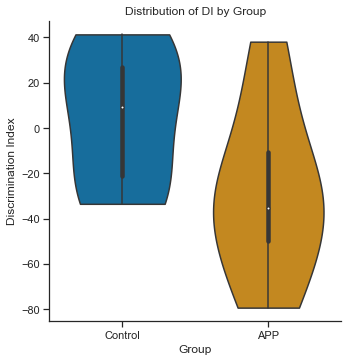

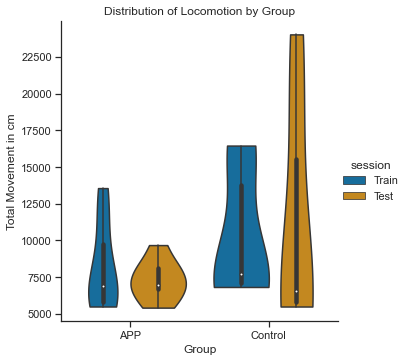

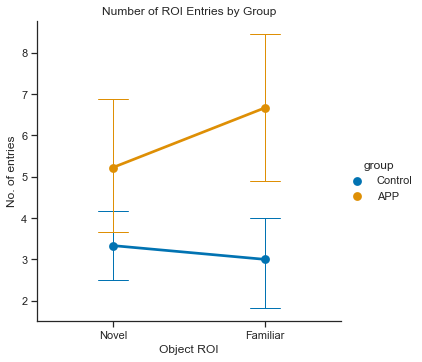

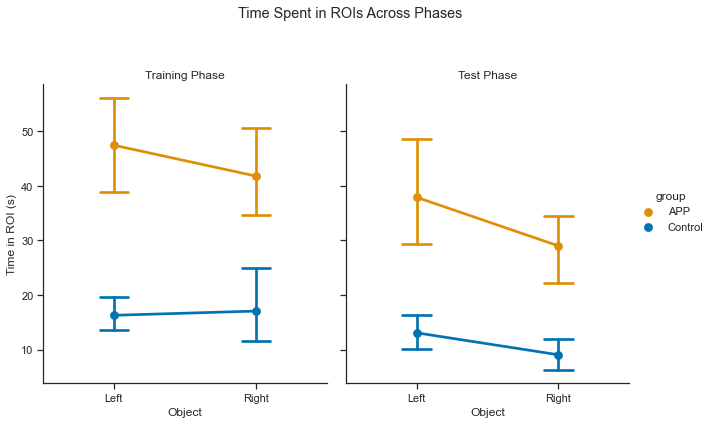

In [219]:
#set palette and adjust graph resolution
sns.set_theme(style = "ticks", palette="colorblind")
plt.rcParams['savefig.dpi'] = 300

palette_colors = sns.color_palette('colorblind')
palette_dict = {'APP' : palette_colors[1], 'Control' : palette_colors[0]}


#violinplot of DI by group
di_plot = sns.catplot(x="group", y="di", kind="violin", cut = 0, split=False, data=session_two_df)
di_plot.ax.set(xlabel='Group', 
               ylabel='Discrimination Index',
               title='Distribution of DI by Group')
#save
di_plot.savefig("di_plot.png") 

#violin plot of locomotion by group 
loco_plot = sns.catplot(x='group', y="t_move_cm", hue="session", kind="violin", cut = 0, data=animals_sorted_df)
loco_plot.ax.set(xlabel='Group',
                ylabel='Total Movement in cm',
                title='Distribution of Locomotion by Group')
#save
loco_plot.savefig("loco_plot.png") 

#pointplot of familiar vs novel entries
entry_df = novel_labelled_new[['group', 'entries_novel', 'entries_familiar']].copy()
entry_long = pd.melt(entry_df, id_vars='group')
entries_plot = sns.catplot(x="variable", y="value", hue="group", kind="point", data=entry_long, errwidth=1, capsize=0.2, palette=palette_dict)
entries_plot.ax.set(xlabel='Object ROI',
                   ylabel='No. of entries',
                   title='Number of ROI Entries by Group')
entries_plot.set_xticklabels((['Novel', 'Familiar']))
#save
entries_plot.savefig("entries_plot.png") 

#pointplots of general exploration roi time s1 / s2
one_roitime_df = session_one_df[['group', 'sum_s_left', 'sum_s_right']].copy()
one_roitime_long = pd.melt(one_roitime_df, id_vars='group')
#one_roitime_plot = sns.catplot(x='variable', y='value', hue='group', kind="point", data=one_roitime_long)

two_roitime_df = session_two_df[['group', 'sum_s_left', 'sum_s_right']].copy()
two_roitime_long = pd.melt(two_roitime_df, id_vars='group')
#two_roitime_plot = sns.catplot(x='variable', y='value', hue='group', kind="point", data=two_roitime_long)

#both pointplots together
one_roitime_long['session'] = 'Train'
two_roitime_long['session'] = 'Test'
roitime_both = pd.concat([one_roitime_long, two_roitime_long])
roitime_both

roitime_plot = sns.catplot(x="variable", y="value", hue="group", col="session", capsize=.2, palette=palette_dict, height=6, aspect=.75,
                kind="point", data=roitime_both)
roitime_plot.set_titles("{col_name}") 
roitime_plot.set_axis_labels(x_var="Object", y_var="Time in ROI (s)")
roitime_plot.set_xticklabels((['Left', 'Right']))
axes = roitime_plot.axes.flatten()
axes[0].set_title("Training Phase")
axes[1].set_title("Test Phase")
roitime_plot.despine(right=True)
roitime_plot.fig.subplots_adjust(top=0.8)
roitime_plot.fig.suptitle('Time Spent in ROIs Across Phases')
#save
roitime_plot.savefig("roitime_plot.png") 

#di_time_df = animals_sorted_df[['group', 'di', 'session']].copy()
#di_time_plot = sns.catplot(x="session", y="di", hue="group", capsize=.2, palette=palette_dict, height =6, aspect= .75, kind="point", data=di_time_df)
di_plot

In [160]:
#performed paired t-test to see if difference in locomotion between s1 and s2 
loco_s1 = animals_sorted_df.query('session == "Test"')['t_move_cm']
loco_s2 = animals_sorted_df.query('session == "Train"')['t_move_cm']

loco_session_wtest = pt.wilcoxon(loco_s1, loco_s2, alternative='two-sided')
loco_session_ttest = pt.ttest(loco_s1, loco_s2, paired=True)
loco_session_wtest
#loco_session_wtest.to_csv("loco_session_wtest.csv")

,W-val,alternative,p-val,RBC,CLES
Wilcoxon,53.0,two-sided,0.719727,-0.116667,0.426667


In [161]:
#compare APP and Control for locomotion
#two-sample(independent) one-tailed t-test
#two-sample because different populations, one-tailed because care about direction - expect control to be higher
loco_app = animals_sorted_df.query('group == "APP"')['t_move_cm']
loco_control = animals_sorted_df.query('group == "Control"')['t_move_cm']

#not normal so mann whitney u test, alternative = less as hypothesise pairs of x to be lower than y 
loco_groups_mwtest = pt.mwu(loco_app, loco_control)
#loco_groups_ttest = pt.ttest(loco_app, loco_control)
loco_groups_mwtest
#loco_groups_mwtest.to_csv("loco_groups_mwtest.csv")

,U-val,alternative,p-val,RBC,CLES
MWU,85.0,two-sided,0.340843,0.212963,0.393519


In [162]:
#compare APP and Control for total time in investigating - normally distributed 
#irrelevant bc mixed anova


#two sample independent one-tailed t-test
#two-sample because different populations, one-tailed because care about direction - expect control to be higher
animals_sorted_df['t_s_inv'] = animals_sorted_df['t_s_left'] + animals_sorted_df['t_s_right']
inv_app = animals_sorted_df.query('group == "APP"')['t_s_inv']
inv_control = animals_sorted_df.query('group == "Control"')['t_s_inv']

inv_groups_ttest = pt.ttest(inv_app, inv_control)
inv_groups_ttest
#inv_groups_ttest.to_csv("inv_groups_ttest.csv")

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,7.821669,21.841424,two-sided,9.003073e-08,"[17.28, 29.76]",2.461296,4.988e+05,1.0


In [208]:
#compare means of APP and Control for Discrimination Index
di_app = session_two_df.query('group == "APP"')['di']
di_con = session_two_df.query('group == "Control"')['di']

di_groups_ttest = pt.ttest(di_app, di_con)
di_groups_ttest
#di_groups_ttest.to_csv("di_groups_ttest.csv")

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-1.891166,12.193163,two-sided,0.082593,"[-71.65, 5.0]",0.95867,1.315,0.391748


In [166]:
#mixed measures anova - one between subjects (group) and one within subjects (session)

aov_df = animals_sorted_df[['mouse id', 'session', 'group', 'di', 't_s_inv', 't_move_cm']].copy()

#aov2 = pt.mixed_anova(dv='t_move_cm', between='group', within='session', subject='mouse id',data=aov_df)
#df = pt.read_dataset('mixed_anova')

aov3 = pt.mixed_anova(dv='t_s_inv', between='group', within='session', subject='mouse id', data=aov_df)

aov3

#aov3.to_csv("aov3.csv", index=False) 


,Source,SS,DF1,DF2,MS,F,p-unc,np2,eps
0,group,3982.97088,1,13,3982.97088,33.742791,0.000061,0.721882,NaN
1,session,45.16587,1,13,45.16587,0.630985,0.441254,0.046291,1.0
2,Interaction,46.63458,1,13,46.63458,0.651504,0.434096,0.047724,NaN
